# Classification Example

[sklearn sample code](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)

In [10]:
from simplegrad.engine import Num
from simplegrad.nn import FeedForward, crossentropy_loss
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
import numpy as np

In [2]:
# get dataset
digits = datasets.load_digits()

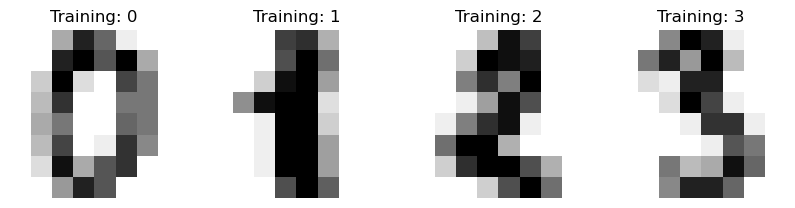

In [3]:
# visualize
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)
plt.show()

In [4]:
# pre-process dataset
X = digits.images.reshape(len(digits.images), -1)
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False)

scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

X_train_nums = [[Num(n) for n in example] for example in X_train_std]
X_test_nums = [[Num(n) for n in example] for example in X_test_std]

In [5]:
print(len(X_train_nums), len(X_train_nums[0]))
print(len(X_test_nums), len(X_test_nums[0]))

1437 64
360 64


In [6]:
# create model
input_size = 64
output_size = 10

hidden_size = [10]
model = FeedForward(input_size, hidden_size, output_size)

In [7]:
# helper function
def get_accuracy_loss(X, y):
    preds = []
    loss = 0
    for x, y_ in zip(X, y):
        out = model.forward(x)
        preds.append(np.argmax(np.array([n.value for n in out])))
        loss += crossentropy_loss([out], [y_]).value

    preds = np.array(preds)
    return (y == preds).sum() / len(y), loss / len(y)

In [8]:
# train (stochastic gradient descent)
epochs = 1 # we sometimes run into overflow errors when training for a long time
# a single epoch here is sufficient to show that the model is working, even
# if we aren't maximizing performance
learning_rate = 0.05

examples_log = []
acc_train_log = []
acc_test_log = []

for epoch in range(epochs):
    total_loss = 0
    for i, (x, y_) in enumerate(zip(X_train_nums, y_train)):
        # forward
        y_pred = model.forward(x)
        loss = crossentropy_loss([y_pred], [y_])
        total_loss += loss.value

        # backward
        model.zero_grad()
        loss.backward()
        model.update_weights(learning_rate)

        if i % 10 == 0:
            print(f'epoch {epoch}, {i+1} / {len(X_train_nums)}: epoch mean loss {total_loss/(i+1):.4f}')
            if i % 100 == 0:
                acc_train, loss_train = get_accuracy_loss(X_train_nums, y_train)
                acc_test, loss_test = get_accuracy_loss(X_test_nums, y_test)
                print(f'\ttrain accuracy={acc_train:.4f}, test accuracy={acc_test:.4f}, train loss={loss_train:.4f}, test loss={loss_test:.4f}')
                
                acc_train_log.append(acc_train)
                acc_test_log.append(acc_test)
                examples_log.append(i + 1)

epoch 0, 1 / 1437: epoch mean loss 1.1023
	train accuracy=0.0974, test accuracy=0.0944, train loss=7.3125, test loss=6.7194
epoch 0, 11 / 1437: epoch mean loss 6.4469
epoch 0, 21 / 1437: epoch mean loss 5.4984
epoch 0, 31 / 1437: epoch mean loss 4.6402
epoch 0, 41 / 1437: epoch mean loss 3.8440
epoch 0, 51 / 1437: epoch mean loss 3.3388
epoch 0, 61 / 1437: epoch mean loss 3.0581
epoch 0, 71 / 1437: epoch mean loss 2.8919
epoch 0, 81 / 1437: epoch mean loss 2.7367
epoch 0, 91 / 1437: epoch mean loss 2.7371
epoch 0, 101 / 1437: epoch mean loss 2.5838
	train accuracy=0.4537, test accuracy=0.3833, train loss=2.8318, test loss=2.6046
epoch 0, 111 / 1437: epoch mean loss 2.4655
epoch 0, 121 / 1437: epoch mean loss 2.4219
epoch 0, 131 / 1437: epoch mean loss 2.3151
epoch 0, 141 / 1437: epoch mean loss 2.2851
epoch 0, 151 / 1437: epoch mean loss 2.1738
epoch 0, 161 / 1437: epoch mean loss 2.0635
epoch 0, 171 / 1437: epoch mean loss 1.9848
epoch 0, 181 / 1437: epoch mean loss 1.9395
epoch 0, 19

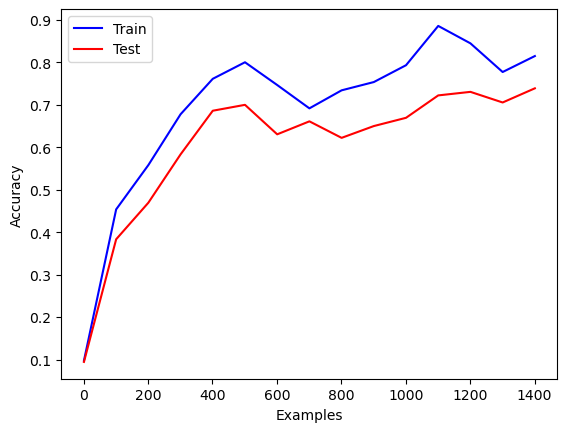

In [11]:
# plot accuracy
plt.plot(examples_log, acc_train_log, color='blue', label='Train')
plt.plot(examples_log, acc_test_log, color='red', label='Test')
plt.xlabel('Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# show classification report
preds = []
for x in X_test_nums:
    out = model.forward(x)
    preds.append(np.argmax(np.array([n.value for n in out])))

predicted = np.array(preds)

print(
    f"Classification report:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        35
           1       0.64      0.78      0.70        36
           2       0.71      0.91      0.80        35
           3       1.00      0.49      0.65        37
           4       0.90      0.73      0.81        37
           5       0.75      0.97      0.85        37
           6       0.57      0.81      0.67        37
           7       0.72      0.81      0.76        36
           8       0.59      0.70      0.64        33
           9       0.91      0.54      0.68        37

    accuracy                           0.73       360
   macro avg       0.78      0.73      0.73       360
weighted avg       0.78      0.73      0.73       360




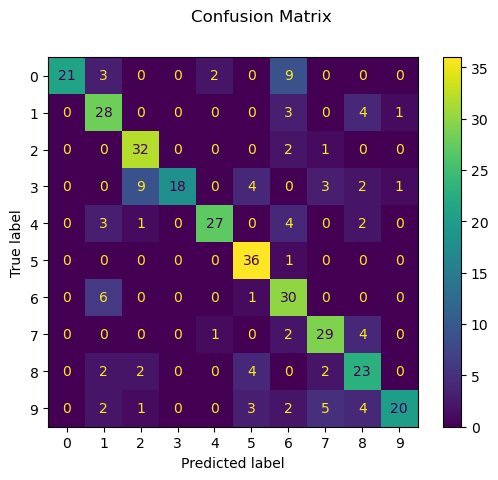

In [17]:
# show confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
plt.show()